# **A/B testing**

**1.Problem definition.**

* Goal: Evaluate whether the new landing page of an e-commerce website can increase (at least a Small Effect) conversion rate (categorical, 0/1) .
* Hypothesis: Null hypothesis (H0): The new landing page design has no effect on conversion rate. / Alternative hypothesis (H1): The new landing page design can increase conversion rate.
* Metrics: <BR>
  -Sampling size on sample data: None (no sampling required as dataset is large enough with 290k+ records) <BR>
  -Conversion rate (testing parameter, difference in proportions) <BR>
  -significance level α: 5% (rule of thumb) <BR>
  -Power β: 80% (rule of thumb) <BR>
  -Minimum Detectable Effect MDE: +2% (rule of thumb for a "Small Effect")

**2.Acquire datasets**

* Import the necessary modules and datasets

In [15]:
#Fundamentals for data analysis
import numpy as np
import pandas as pd
import random as rnd

#EDA
from sklearn.preprocessing import LabelEncoder


#A/B testing
from scipy import stats
from tabulate import tabulate
from statsmodels.stats.proportion import proportions_ztest, proportion_confint




# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Import the dataset
file_name = 'ab_data.csv'  # Replace with your CSV file name
df = pd.read_csv(file_name)

df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**3.Data cleaning**

* Perform data cleaning to deal with data quality issues such as missing records
* Compute the metric to measure: mean conversion rates of control/treatment groups

In [21]:
#check for and resolve N/A(missing) values in datasets

df.isna().sum() # All = 0 so no missing value

#check for unique users in the dataset

df = df[~df['user_id'].duplicated(keep='first')] #keep only unique users
df

#check if (1)all users in the control group are given the old_page design or (2)those in treatment group are given the new_page design.
# Keep only rows that satisfy either conditions

df.groupby('group')['landing_page'].value_counts()

df[(df['group']=='control') & (df['landing_page']=='old_page')] #rows fitting condition 1

df[(df['group']=='treatment') & (df['landing_page']=='new_page')] #rows fitting condition 2


df = df[((df['group']=='control') & (df['landing_page']=='old_page'))|((df['group']=='treatment') & (df['landing_page']=='new_page'))] #rows fitting condition 1 OR 2

#Convert timestamp into dates at day level for better grouping and analysis

df['date'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d')

#Calculate the daily mean conversion rate per group

df_daily_mean = df.groupby(['group','date'])['converted'].mean()

daily_mean = pd.DataFrame(df_daily_mean)

daily_mean

#Rename the clean dataset


df_clean = df
df_clean






,user_id,timestamp,group,landing_page,converted,date
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,2017-01-03
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,2017-01-12
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,2017-01-22
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,2017-01-15


**4.Exploratory Data Analysis**

* Explore the data for summary statistics and to examine any immediately visible trends

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288540 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       288540 non-null  int64 
 1   timestamp     288540 non-null  object
 2   group         288540 non-null  object
 3   landing_page  288540 non-null  object
 4   converted     288540 non-null  int64 
 5   date          288540 non-null  object
dtypes: int64(2), object(4)
memory usage: 15.4+ MB


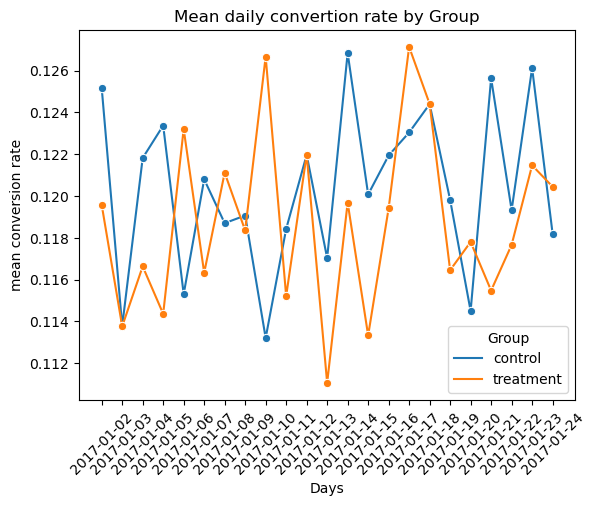

In [5]:
#Mean, count, and standard deviation summary
df_clean.info()

df_clean.groupby('landing_page')['converted'].agg({'mean','std','count'})

df_clean.groupby('landing_page')['converted'].value_counts()


#lineplot between dates and daily mean conversion rate



sns.lineplot(data=daily_mean, x='date', y='converted', hue='group', marker='o') #marker 'o' means dots to represent each datapoint in the graph
plt.title('Mean daily convertion rate by Group')
plt.xlabel('Days')
plt.ylabel('mean conversion rate')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

**5.Statistical Testing**

* Use statistical tests to determine if the observed differences between the groups are statistically significant. Common tests include t-tests or chi-square tests.

In [20]:
#Compute the metric: conversion rate of control and treatment groups
df_clean.groupby('group')['converted'].mean()

control_conversion = df_clean[(df_clean['group']=='control') & (df_clean['converted']==1)]['converted'].count()
control_conversion


treatment_conversion = df_clean[(df_clean['group']=='treatment') & (df_clean['converted']==1)]['converted'].count()
treatment_conversion

#To run parametric tests, assume the data is (1)randomly sampled and (2)independent. The sample size is also (2)large enough (144226 sample for control / 144314 records for treatment group).
#So a parametric test can be run.
# This is a difference in proportion A/B testing for two groups (control/treatment). So the two sample proportion ztest is used.

    #Calculate the total number of rows for each group
n_control = df_clean[df_clean['group']=='control']['user_id'].count()
n_control

n_treatment= df_clean[df_clean['group']=='treatment']['user_id'].count()
n_treatment

    #Assign group lists

converted_abtest = [control_conversion, treatment_conversion]
n_abtest = [n_control, n_treatment]

    #Calculate p-value and confidence intervals

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

z_stat, pvalue = proportions_ztest(converted_abtest, nobs = n_abtest)

(A_lo95, B_lo95), (A_up95, B_up95) = proportion_confint(converted_abtest, nobs=n_abtest, alpha=0.05)

    #Print the p-value and confidence intervals

print(f'p-value: {pvalue:.4f}')
print(f'Group A 95% CI : [{A_lo95:.4f}, {A_up95:.4f}]')
print(f'Group B 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]')

#Calculating effect size for difference in proportions

control_conversion_mean = df_clean[df_clean['group']=='control']['converted'].mean()
control_conversion_mean

treatment_conversion_mean = df_clean[df_clean['group']=='treatment']['converted'].mean()
treatment_conversion_mean


from statsmodels.stats.proportion import proportion_effectsize
effect_size_std = proportion_effectsize(treatment_conversion_mean, control_conversion_mean)
print(effect_size_std)







p-value: 0.1956
Group A 95% CI : [0.1186, 0.1220]
Group B 95% CI : [0.1171, 0.1204]
-0.004818840181646578


**6.Result interpretation**

* Interpret the result.

In [ ]:
# The p-value calculated is 0.1956 > α (=0.05), so we fail to reject H0. That means we cannot reject the hypothesis that the new landing page has no effect on conversion rate.
# The effect size calculated is -0.0048 < MDE (+0.02), so the effect of the new landing page is smaller than the defined minimum. That means the effect is too insignificant to cause any business action.


**7.Conclusion and reporting**

* Draw conclusion.
* Export the processed data for loading to SQL server.
* Use the loaded data to perform data visualization (e.g. Tableau / PowerBI)

In [ ]:
#In conclusion, at a 95% confidence interval the new landing page actually has no effect on conversion rate.

#Exporting data for loading to databases
df_clean.to_csv('/kaggle/working/output.csv', index=False)
